In [12]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

from datetime import datetime

import stac

In [13]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto (-46.872, -17.150).
item = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                "intersects": {"type": "Point",
                                               "coordinates": [-46.872, -17.150]},
                                'limit': 200})

# Mostrar quantas imagens foram recuperadas
len(item.features)

93

In [14]:
links = {}

# Percorrer todos o itens obtidos ds STAC
for i in item.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links[date] = i['assets']['sr_ndvi']['href']

# Mostrar dicionário de links
links

{'2020-08-26': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-08/220072/LC08_L1TP_220072_20200826_20200905_01_T1_sr_ndvi.tif',
 '2020-08-10': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-08/220072/LC08_L1TP_220072_20200810_20200821_01_T1_sr_ndvi.tif',
 '2020-07-25': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-07/220072/LC08_L1TP_220072_20200725_20200807_01_T1_sr_ndvi.tif',
 '2020-07-09': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-07/220072/LC08_L1TP_220072_20200709_20200721_01_T1_sr_ndvi.tif',
 '2020-06-23': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-06/220072/LC08_L1TP_220072_20200623_20200707_01_T1_sr_ndvi.tif',
 '2020-06-07': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-06/220072/LC08_L1TP_220072_20200607_20200625_01_T1_sr_ndvi.tif',
 '2020-05-22': 'http://brazildatacube.dpi.inpe.br/Repository/Archive/LC8SR/2020-05/220072/LC08_L1TP_220072_20200522_20200607_01_T1

In [15]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/pts_fora_23n.geojson')

# Gerar duas listas (lat e lon) com as coordenadas dos pontos
lat = []
lon = []
for i in df.geometry:
    lon.append(i.x)
    lat.append(i.y)

In [16]:
# Para evitar a execução dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out = np.load('./DADOS/out_fora.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links.items():
        # Abrir a imagem da URL
        with rasterio.open(v) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample(zip(lon,lat))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_fora.npy', out)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo aberto com sucesso!


In [17]:
df

,id,nome,geometry
0,15,brilho,POINT (306859.187 -1935524.147)
1,1,agua,POINT (297848.593 -1900765.782)
2,2,mineracao,POINT (299483.916 -1902645.640)
3,3,cidade,POINT (300752.438 -1904449.081)
4,4,cidade,POINT (300653.096 -1906405.356)
5,5,mata,POINT (297466.508 -1908101.813)
6,6,mata,POINT (276864.489 -1900185.013)
7,7,agua,POINT (250378.362 -1906573.473)
8,8,solo,POINT (288158.919 -1849940.846)
9,9,rocha,POINT (316532.546 -1868441.398)


In [18]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out.items():
    df.insert(loc=1,column=datetime.strptime(k,'%Y-%m-%d').date(), value=v)
    
df = df.drop(['nome', 'geometry'], 1)
df.rename(columns={'id': 'date'}, inplace=True)
df = df.set_index('date').T/10000

In [19]:
df

date,15,1,2,3,4,5,6,7,8,9,10,11,12,13,14,13
2016-08-15,0.0703,0.0565,0.0605,0.1941,0.1499,0.7156,0.5634,0.0746,0.1946,0.1894,0.2188,0.2258,0.2840,0.2989,0.2754,0.3242
2016-08-31,0.0377,-0.4059,0.0074,0.2865,0.1650,0.7157,0.7708,0.1170,0.2010,0.1878,0.2506,0.2995,0.3474,0.1717,0.1833,0.2614
2016-09-16,0.0957,0.0809,0.0753,0.1585,0.1487,0.3774,0.1545,-0.0871,0.2075,0.1435,0.1710,0.1418,0.1890,0.1270,0.1883,0.2034
2016-10-02,0.0462,-0.1261,0.0132,0.2456,0.1679,0.6845,0.7548,-0.0913,0.2158,0.1739,0.2371,0.3127,0.3869,0.2927,0.2783,0.3134
2016-10-18,0.1024,-0.1049,0.0164,0.2240,0.1897,0.7386,0.7282,0.0798,0.2454,0.1605,0.2217,0.3797,0.4074,0.3212,0.3139,0.3494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-23,0.0343,-0.1130,0.0122,0.2576,0.2212,0.8166,0.8199,-0.4030,0.4604,0.5327,0.5231,0.4843,0.5526,0.5199,0.5733,0.4943
2020-07-09,0.0368,-0.3849,0.0071,0.2601,0.1766,0.7944,0.8048,-0.2979,0.3321,0.4525,0.4699,0.4480,0.5164,0.4790,0.5399,0.4728
2020-07-25,0.0124,-0.2666,0.0084,0.2087,0.2016,0.8018,0.8130,-0.3481,0.2710,0.3937,0.4241,0.4078,0.4850,0.4302,0.4931,0.4017
2020-08-10,0.0091,-0.3388,0.0094,0.2534,0.1716,0.7950,0.8127,-0.4129,0.3096,0.3493,0.3884,0.3827,0.4416,0.3728,0.4490,0.3952


In [20]:
from datetime import date

anos_ag = {'2016':[date(2016, 9, 1), date(2017, 8, 31)],
           '2017':[date(2017, 9, 1), date(2018, 8, 31)],
           '2018':[date(2018, 9, 1), date(2019, 8, 31)],
           '2019':[date(2019, 9, 1), date(2020, 8, 31)]}

KeyError: 16

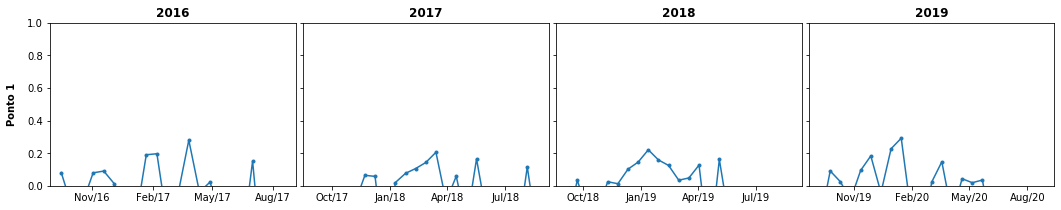

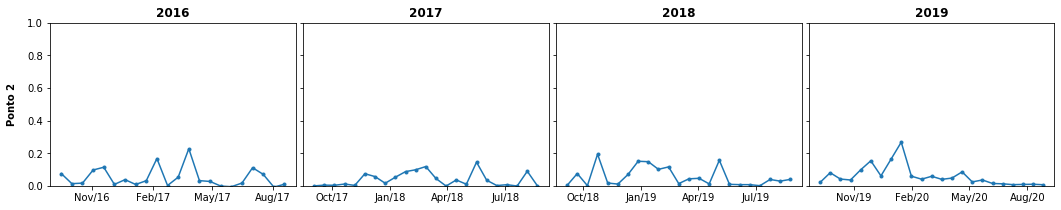

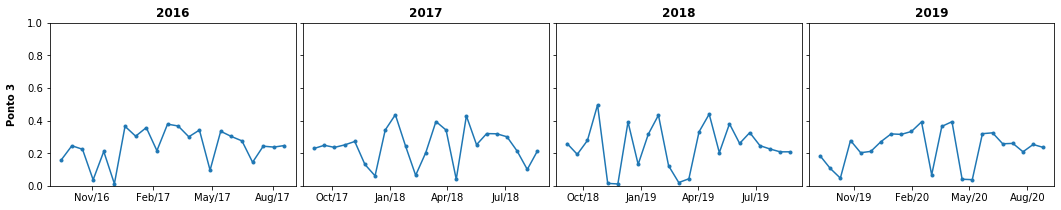

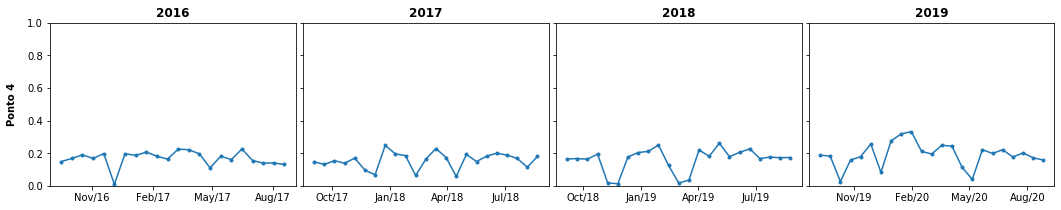

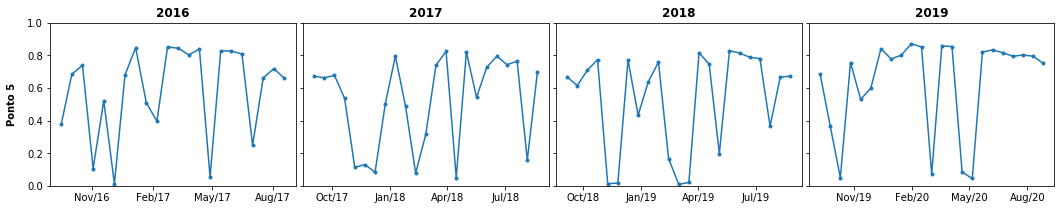

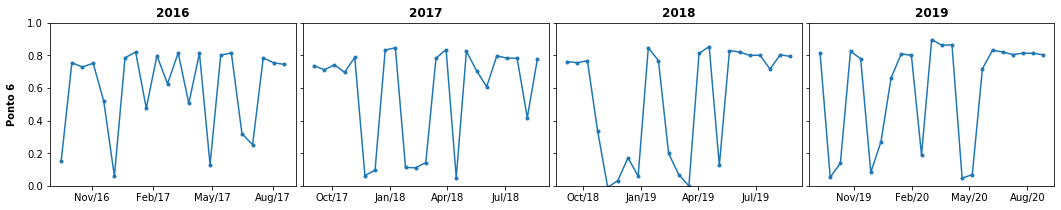

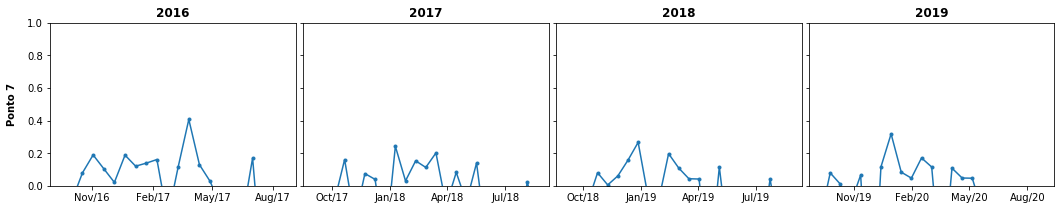

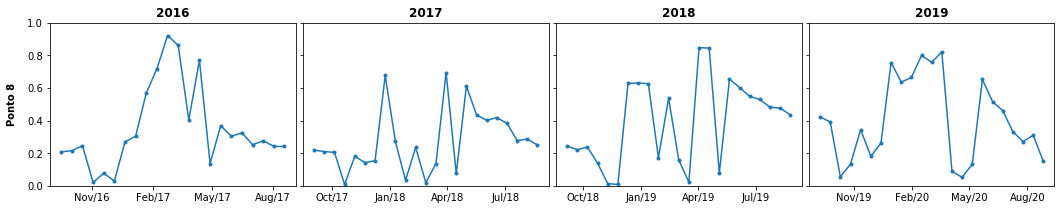

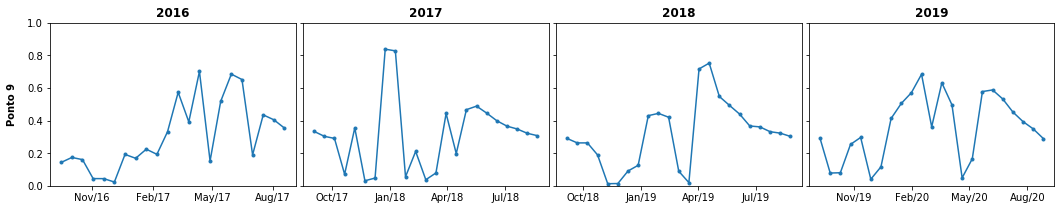

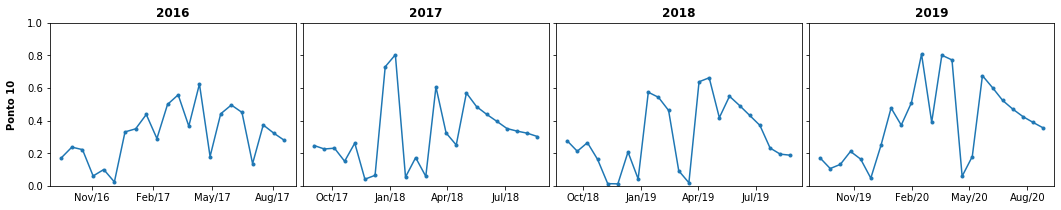

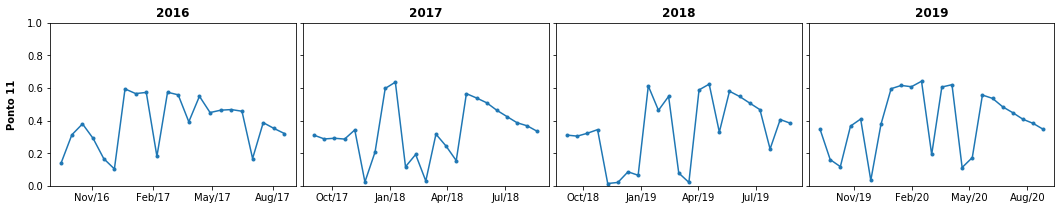

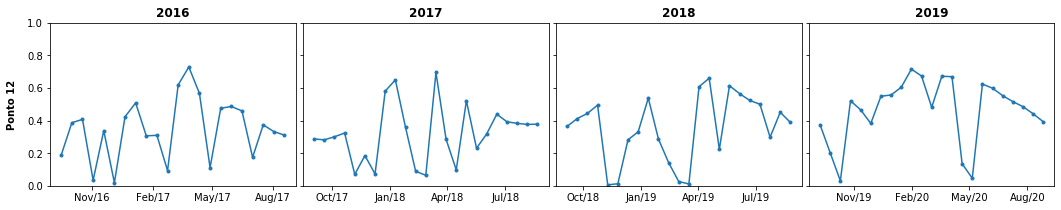

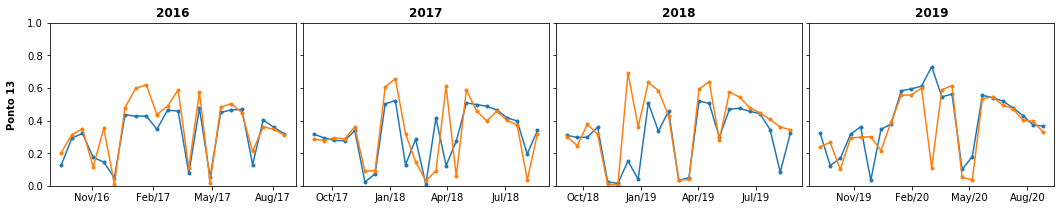

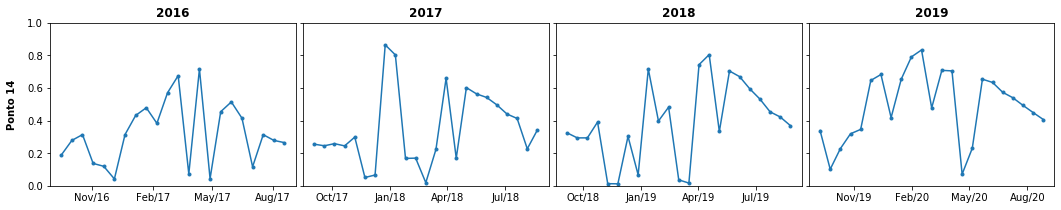

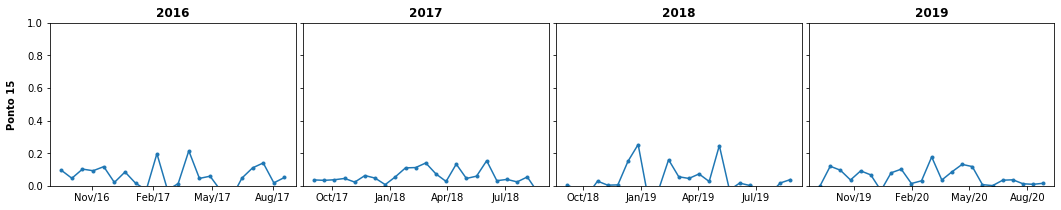

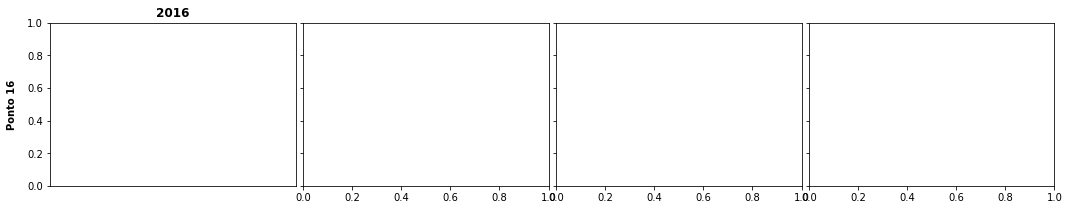

In [21]:
for i in range(1,df.shape[1]+1):
    
    fig, ax = plt.subplots(1,len(anos_ag),figsize=(18,3),sharey=True)
    fig.subplots_adjust(wspace = .03)
    
    for axs, (ano, intervalo) in zip(ax.flat, anos_ag.items()):
        axs.set_ylim(0,1)
    
        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        axs.get_xaxis().set_major_locator(months)
        axs.get_xaxis().set_major_formatter(month_fmt)
               
        axs.set_title(ano,weight='bold')
        
        if axs == ax.flat[0]:
            axs.set_ylabel('Ponto {}'.format(i),labelpad=10,weight='bold')
        
        axs.plot(df.loc[intervalo[0]:intervalo[1],i],marker='.');